# Projet 3 : Anticipez les besoins en consommation électrique de batiments  
## Notebook de nettoyage de la base de données  
Ce notebook contient le nettoyage de la base de données des relevées de consommation de la ville de Seattle issus du site https://data.seattle.gov  
### Contexte et objectifs :  
La ville de Seattle a effectué des relevés de consommation énergétique et des émissions des gaz à effet de serres des batiments de la ville.  
Cependant ces relevés sont très couteux et donc la ville voudrait prédire ces valeurs pour les batiments dont les mesures ne sont pas disponibles.  
Le but est donc de prédire la consommation énergétique et les émissions de GES des batiments de la ville.  
Pour réaliser cette prédiction, on pourra se baser sur les données du permis d'exploitation, afin d'éviter tout relevés.  
De plus, la ville voudrait connaitre l'apport de l'Energy Star Score dans cette prédiction. En effet, cette variable est fastidieuse à calculer et donc on voudrait savoir si cette information apporte une plus value ou non dans la prédiction.

### Modules Python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import ast

### Fonctions utiles 

In [2]:
def location2dict(value) :
    """
    to convert the str value of location variable into a dict
    parameters : value : str
    returns : dict
    """
    out = ast.literal_eval(value.replace("\''", "\""))
    out['human_address'] = ast.literal_eval(out['human_address'])
    return out

In [3]:
def is_float(value, min=-np.inf, max=np.inf) :
    """
    function to verify if the value is a float in the range [min, max]
    parameters : value : value to check
                 min : float : minimum value 
                 max : float : maximum value
    returns : float or np.NaN
    """
    if pd.notnull(value) :
        if type(value) in [float, int] and value <= max and value >= min :
            return value
        else :
            print(f"Wrong value : {value} of type {type(value)} => ignored")
            return np.NaN
    else :
        return np.NaN

In [4]:
def is_int(value, min=-np.inf, max=np.inf) :
    """
    function to verify if the value is a int in the range [min, max]
    parameters : value : value to check
                 min : float : minimum value 
                 max : float : maximum value
    returns : float or np.NaN
    """
    if pd.notnull(value) :
        if type(value) == float :
            if value.is_integer() :
                value = int(value)
            else :
                print(f"Wrong value : {value} is not an integer => ignored")
                return np.NaN
        elif type(value) == str :
            if value.isdigit() :
                value = int(value)
            else :
                print(f"Wrong value : {value} is not an integer => ignored")
                return np.NaN
    else :
        return np.NaN
    
    if type(value) == int and value <= max and value >= min :
            return value
    else :
        print(f"Wrong value : {value} of type {type(value)} => ignored")
        return np.NaN
    

### Chargement des données  
Les données sont disponibles sur 2 années.  
Chaque année est regroupée dans un fichier.  
Les deux années sont donc chargées séparément, afin de vérifier l'homogénéité des deux datasets.

In [5]:
DATA_2015 = pd.read_csv('data/2015-building-energy-benchmarking.csv', 
                        sep=',')
DATA_2016 = pd.read_csv('data/2016-building-energy-benchmarking.csv', 
                        sep=',')
print(f"Nombre d'observations en 2015 = {len(DATA_2015)}")
print(f"Nombre de variables en 2015   = {len(DATA_2015.columns)}")
print(f"Nombre d'observations en 2016 = {len(DATA_2016)}")
print(f"Nombre de variables en 2016   = {len(DATA_2016.columns)}")

Nombre d'observations en 2015 = 3340
Nombre de variables en 2015   = 47
Nombre d'observations en 2016 = 3376
Nombre de variables en 2016   = 46


In [6]:
print(f"Liste des variables en 2015 : \n{DATA_2015.columns}")
print(f"Liste des variables en 2016 : \n{DATA_2016.columns}")

Liste des variables en 2015 : 
Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e

### harmonisation des deux datasets
#### identification des variables non présentes les deux années

In [8]:
print(f"Variables présentes en 2015 mais pas en 2016 :\n"+\
      f"{[col for col in DATA_2015.columns if col not in DATA_2016.columns]}")
print(f"Variables présentes en 2016 mais pas en 2015 :\n"+\
      f"{[col for col in DATA_2016.columns if col not in DATA_2015.columns]}")


Variables présentes en 2015 mais pas en 2016 :
['Location', 'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'Comment', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'City Council Districts', 'SPD Beats', 'Zip Codes']
Variables présentes en 2016 mais pas en 2015 :
['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude', 'Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


#### Comments
La variable a uniquement changé de nom :  
Je décide de renommer Comment en Comments

In [9]:
DATA_2015['Comments'] = DATA_2015['Comment']
DATA_2015.drop('Comment', axis=1, inplace=True)

#### GHGEmissionsIntensity
il semble que les variables GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity soient équivalentes :  
on le vérifie :

In [10]:
print("2015 :")
print(DATA_2015[['OSEBuildingID', 'GHGEmissionsIntensity(kgCO2e/ft2)']].head(10))
print(f"Valeur moyenne = {DATA_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].mean()}")
print(f"Deviation standard = {DATA_2015['GHGEmissionsIntensity(kgCO2e/ft2)'].std()}")
print("2016 : ")
print(DATA_2016[['OSEBuildingID', 'GHGEmissionsIntensity']].head(10))
print(f"Valeur moyenne = {DATA_2016['GHGEmissionsIntensity'].mean()}")
print(f"Deviation standard = {DATA_2016['GHGEmissionsIntensity'].std()}")

2015 :
   OSEBuildingID  GHGEmissionsIntensity(kgCO2e/ft2)
0              1                               2.64
1              2                               2.38
2              3                               1.92
3              5                              31.38
4              8                               4.02
5              9                               2.81
6             10                               2.37
7             11                               1.77
8             12                               1.83
9             13                               2.51
Valeur moyenne = 0.9853393393393379
Deviation standard = 1.6371718086243117
2016 : 
   OSEBuildingID  GHGEmissionsIntensity
0              1                   2.83
1              2                   2.86
2              3                   2.19
3              5                   4.67
4              8                   2.88
5              9                   3.10
6             10                   2.12
7             11 

Il est bien confirmé que les deux variables sont équivalentes :  
Pour garder l'information de l'unité, on renomme la variable GHGEmissionsIntensity en GHGEmissionsIntensity(kgCO2e/ft2)

In [11]:
DATA_2016['GHGEmissionsIntensity(kgCO2e/ft2)'] = DATA_2016['GHGEmissionsIntensity'] 
DATA_2016.drop('GHGEmissionsIntensity', axis=1, inplace=True)

#### TotalGHGEmissions
Est ce que les variables TotalGHGEmissions et GHGEmissions(MetricTonsCO2e) représentent la même chose?  


In [12]:
print("2015 :")
print(DATA_2015[['OSEBuildingID', 'GHGEmissions(MetricTonsCO2e)']].head(10))
print(f"Valeur moyenne = {DATA_2015['GHGEmissions(MetricTonsCO2e)'].mean()}")
print(f"Déviation standard = {DATA_2015['GHGEmissions(MetricTonsCO2e)'].std()}")
print("2016 : ")
print(DATA_2016[['OSEBuildingID', 'TotalGHGEmissions']].head(10))
print(f"Valeur moyenne = {DATA_2016['TotalGHGEmissions'].mean()}")
print(f"Déviation standard = {DATA_2016['TotalGHGEmissions'].std()}")

2015 :
   OSEBuildingID  GHGEmissions(MetricTonsCO2e)
0              1                        249.43
1              2                        263.51
2              3                       2061.48
3              5                       1936.34
4              8                        507.70
5              9                        304.62
6             10                        208.46
7             11                        199.99
8             12                        331.61
9             13                        170.00
Valeur moyenne = 110.09410210210189
Déviation standard = 409.4501794730603
2016 : 
   OSEBuildingID  TotalGHGEmissions
0              1             249.98
1              2             295.86
2              3            2089.28
3              5             286.43
4              8             505.01
5              9             301.81
6             10             176.14
7             11             221.51
8             12             392.16
9             13             151.

Les deux variables sont bien équivalentes :  
TotalGHGEmissions est donc renommée GHGEmissions(MetricTonsCO2e)

In [13]:
DATA_2016['GHGEmissions(MetricTonsCO2e)'] = DATA_2016['TotalGHGEmissions']
DATA_2016.drop('TotalGHGEmissions', axis=1, inplace=True)

les variables Location et  Address, City, State, ZipCode, Lattitude et Longitude donnent des informations de localisations :  
vérifions !

In [14]:
pd.set_option('display.max_colwidth', None)

In [15]:
DATA_2015[['OSEBuildingID','Location']].head()

,OSEBuildingID,Location
0,1,"{'latitude': '47.61219025', 'longitude': '-122.33799744', 'human_address': '{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}"
1,2,"{'latitude': '47.61310583', 'longitude': '-122.33335756', 'human_address': '{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}"
2,3,"{'latitude': '47.61334897', 'longitude': '-122.33769944', 'human_address': '{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}"
3,5,"{'latitude': '47.61421585', 'longitude': '-122.33660889', 'human_address': '{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98101""}'}"
4,8,"{'latitude': '47.6137544', 'longitude': '-122.3409238', 'human_address': '{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE"", ""state"": ""WA"", ""zip"": ""98121""}'}"


La variable Location regroupe donc les variables latitude, longitude, address, city, state et zipcode.  
Il est donc possible de récréer ces variables et de supprimer Location.  
Pour cela on va transformer la variable Location en dict.  

In [16]:
DATA_2015['Location'] = DATA_2015['Location'].apply(location2dict)

In [17]:
# Création des nouvelles variables
DATA_2015['Latitude'] = DATA_2015['Location'].apply(lambda x : x['latitude'])
DATA_2015['Longitude'] = DATA_2015['Location'].apply(lambda x : x['longitude'])
DATA_2015['Address'] = DATA_2015['Location'].apply(lambda x : x['human_address']['address'])
DATA_2015['City'] = DATA_2015['Location'].apply(lambda x : x['human_address']['city'])
DATA_2015['State'] = DATA_2015['Location'].apply(lambda x : x['human_address']['state'])
DATA_2015['ZipCode'] = DATA_2015['Location'].apply(lambda x : x['human_address']['zip'])

#suppression de la variable Location
DATA_2015.drop('Location', axis=1, inplace=True)
DATA_2015.drop('Zip Codes', axis=1, inplace=True)

#### Les autres variables :
Il reste des variables présentes en 2015 mais pas en 2016 : 
- 2010 Census Tracts : variable liée au recensement
- Seattle Police Department Micro Community Policing Plan Areas, SPD Beats : variables liées à la Police (Seattle Police Department)
- City Council Districts : variable liée aux quartiers de la ville  
  
A première vue, ces variables n'ont aucun rapport avec la consommation energétique des batiments.  
Elles sont donc simplement supprimées.  
  

Concernant la variable OtherFuelUse(kBtu), elle semble être beaucoup plus importante. De ce fait, on décide de conserver cette variable, en l'initialisant à 0 en 2016.  
Nous reviendrons sur cette variable plus loin dans ce notebook.

#### OtherFuelUse(kBtu)

In [18]:
DATA_2016['OtherFuelUse(kBtu)'] = 0

In [19]:
for column in ["2010 Census Tracts", "Seattle Police Department Micro Community Policing Plan Areas",
              "SPD Beats", "City Council Districts"] :
    DATA_2015.drop(column, axis=1, inplace=True)

#### Vérifications de l'harmonie dans les colonnes :

In [20]:
print(f"Variables présentes en 2015 mais pas en 2016 :\n"+\
      f"{[col for col in DATA_2015.columns if col not in DATA_2016.columns]}")
print(f"Variables présentes en 2016 mais pas en 2015 :\n"+\
      f"{[col for col in DATA_2016.columns if col not in DATA_2015.columns]}")

Variables présentes en 2015 mais pas en 2016 :
[]
Variables présentes en 2016 mais pas en 2015 :
[]


Les colonnes sont maintenant homogènes

### Détections de doublons
on va vérifier que l'ID du batiment n'est présente qu'une seule fois.

In [21]:
effectifs_2015 = DATA_2015['OSEBuildingID'].value_counts()
print(f"Nombre de doublons en 2015 = {len(effectifs_2015[effectifs_2015>1])}")
effectifs_2016 = DATA_2016['OSEBuildingID'].value_counts()
print(f"Nombre de doublons en 2016 = {len(effectifs_2016[effectifs_2016>1])}")

Nombre de doublons en 2015 = 0
Nombre de doublons en 2016 = 0


### Regroupement des deux datasets
Puisque les variables renseignées entre les deux années sont les mêmes, il est possible de regrouper les deux jeux de données en un seul.  
Cela permet d'avoir plus d'observations, et de tenir compte de variations annuelles, telles que la température moyenne par exemple, qui peut engendrer des fluctuations de consommations énergétques.  
De plus la variable Datayear peut permettre de savoir à quel dataset original les données appartiennent.  
On vérifie dans un premier temps que la variable DataYear est correctemetn renseignée.

In [22]:
print(DATA_2015['DataYear'].value_counts(dropna=False))
print(DATA_2016['DataYear'].value_counts(dropna=False))

2015    3340
Name: DataYear, dtype: int64
2016    3376
Name: DataYear, dtype: int64


In [23]:
DATA = pd.concat([DATA_2015, DATA_2016], axis=0, ignore_index=True)
print(f"Nombre d'observations dans le dataset : {len(DATA)}")
print(f"Nombre de variables dans le dataset : {len(DATA.columns)}")

Nombre d'observations dans le dataset : 6716
Nombre de variables dans le dataset : 47


### Analyse du taux de complétion :
Avant de sélectionner des variables on étudie lesquelles sont le plus renseigner pour sélectionner en priorité celles avec un taux de complétion maximale.

In [24]:
completion = {"lignes vides": {}, "taux de completion":{}}
for column in DATA.columns :
    completion["lignes vides"][column] = len(DATA[pd.isnull(DATA[column])])
    completion["taux de completion"][column] = len(DATA[pd.notnull(DATA[column])])/len(DATA)*100
completion = pd.DataFrame(completion)
completion.sort_values('taux de completion', inplace=True)
completion

,lignes vides,taux de completion
Comments,6703,0.193568
Outlier,6600,1.727219
YearsENERGYSTARCertified,6487,3.409768
ThirdLargestPropertyUseTypeGFA,5560,17.212627
ThirdLargestPropertyUseType,5560,17.212627
SecondLargestPropertyUseTypeGFA,3478,48.213222
SecondLargestPropertyUseType,3478,48.213222
ENERGYSTARScore,1623,75.833830
LargestPropertyUseTypeGFA,156,97.677189
LargestPropertyUseType,156,97.677189


### Selection des observations conformes
La variables ComplianceStatus informe sur la conformité des observations.  
On peut alors sélectionner uniquement les observations conformes grâce à cette variable.

In [25]:
print(DATA['ComplianceStatus'].value_counts(dropna=False))

Compliant                       6548
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Not Compliant                      3
Name: ComplianceStatus, dtype: int64


On concerve uniquement les observations "Compliant" compte tenue de la faible représentation des autres valeurs

In [26]:
DATA = DATA[DATA['ComplianceStatus'] == "Compliant"]

### Choix des variables utiles pour la prédiction
Les variables à prédire sont :  
- GHGEmissions(MetricTonsCO2e) : pour les émissions des GES
- SiteEnergyUseWN(kBtu) : pour la consommation énergétique. Les valeurs normalisées par la météo pour être indépendant de ce paramètre.

Les variables utilisées pour la prédiction sont :  
- les variables demandées dans le projet :
    - ENERGYSTARScore : apport de cette variable 
  
  
- les variables pour identifier et caractériser le batiment :
    - OSEBuildingID : ID du batiment
    - BuildingType: Type de batiment  
    - PrimaryPropertyType : utilisation principale
    - YearBuilt : année de construction, peut impacter la qualité de l'isolation par exemple
    - NumberofFloors : informe de la taille de l'immeuble
    - NumberofBuildings : Nombre d'immeuble 
    - PropertyGFATotal : surface totale
    - PropertyGFAParking : surface du parking
    - PropertyGFABuilding(s) : surface de l'immeuble
    - LargestPropertyUseType, LargestPropertyUseTypeGFA : Type de l'usage principale et de la surface associée à cette utilisation
    - SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA : Type de l'usage secondaire et de la surface associée à cette utilisation
    - ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA : Type de l'usage tertiaire et de la surface associée à cette utilisation
    
    
- les variables concernant la consommation énergétique :
    - Electricity(kWh), Electricity(kBtu) : consommation électrique 
    - NaturalGas(kBtu) : consommation de gaz
    - SteamUse(kBtu) : consommation de vapeur
    - OtherFuelUse(kBtu) : autre consommation énergétique
    
    
- DataYear : pour concerver la date du relevée
- Outlier : pour le traitement des outliers, voir plus loin

Les variables supprimées :  
- PropertyName : le nom de la propriété ne renseigne pas de la consommation électrique
- Latitude, Longitude, Address, City, State, ZipCode, Neighborhood, CouncilDistrictCode: la localisation exacte n'a pas à entrer en compte dans la prédiction.
- Comments : Les commentaires sont peu renseignées et ne sont a priori pas utile
- ComplianceStatus : déjà utilisé
- DefaultData : La variable n'est pas expliqué, on décide de ne pas la conserver
- TaxParcelIdentificationNumber : information sur la parcelle
- YearsENERGYSTARCertified : l'année de la certification n'impacte pas les valeurs
- SiteEnergyUse(kBtu) : on préfère prédire les valeurs normalisée par la météo
- ListOfAllPropertyUseTypes : déjà capté par le détail des principales, secondaire etc. 
- GHGEmissionsIntensity(kgCO2e/ft2) : il a été décidé de préduire la consommation totale du batiment et non pas ft2
- SiteEUI(kBtu/sf) : on ne concerve pas les données normalisées à la surface
- SiteEUIWN(kBtu/sf) : on ne concerve pas les données normalisées à la surface
- SourceEUI(kBtu/sf) : on ne concerve pas les données normalisées à la surface
- SourceEUIWN(kBtu/sf) : on ne concerve pas les données normalisées à la surface
- NaturalGas(therms) : toutes les autres consommations sont données en kBtu
- Electricity(KWh) : toutes les autres consommations sont données en kBtu



### suppression des variables non utilisées

In [28]:
removed_columns = ["PropertyName", "Latitude", "Longitude", "Address", "City", "State", "ZipCode", "Neighborhood", \
                  "CouncilDistrictCode", "Comments", "ComplianceStatus", "DefaultData", "TaxParcelIdentificationNumber",\
                 "YearsENERGYSTARCertified", "ListOfAllPropertyUseTypes", \
                 "GHGEmissionsIntensity(kgCO2e/ft2)", "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)",\
                 "SourceEUIWN(kBtu/sf)", "NaturalGas(therms)", "Electricity(kWh)"]

In [29]:
for column in removed_columns :
    if column in DATA.columns :
        DATA.drop(column, axis=1, inplace=True)
    else :
        print(f"{column} is not in the dataframe")

### Vérification des variables sélectionnées

In [30]:
selected_columns = ["GHGEmissions(MetricTonsCO2e)", "SiteEnergyUseWN(kBtu)", "SiteEnergyUse(kBtu)", "ENERGYSTARScore", "OSEBuildingID", \
                   "BuildingType", "PrimaryPropertyType", "YearBuilt", "NumberofFloors", "NumberofBuildings", \
                   "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "LargestPropertyUseType",\
                   "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", \
                   "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA", "Electricity(kBtu)", "NaturalGas(kBtu)",\
                   "SteamUse(kBtu)", "OtherFuelUse(kBtu)", "DataYear", "Outlier"]

In [31]:
for column in selected_columns :
    if column not in DATA.columns :
        print(f"Warning : {column} is not in the Dataframe")

### Nettoyage des données 
#### variables de type float
On vérifie que les valeurs soient des floats et supérieures à 0

In [32]:
for column in ["GHGEmissions(MetricTonsCO2e)", "SiteEnergyUseWN(kBtu)","PropertyGFATotal", "PropertyGFAParking", \
               "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", \
               "ThirdLargestPropertyUseTypeGFA", "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", \
               "OtherFuelUse(kBtu)" ] :
    print("="*50)
    print(column)
    print(f"Valeurs manquantes avant nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")
    DATA[column] = DATA[column].apply(is_float, min=0)
    print(f"Valeurs manquantes après nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")

GHGEmissions(MetricTonsCO2e)
Valeurs manquantes avant nettoyage : 11 soit 0.002%
Wrong value : -0.8 of type <class 'float'> => ignored
Valeurs manquantes après nettoyage : 12 soit 0.002%
SiteEnergyUseWN(kBtu)
Valeurs manquantes avant nettoyage : 8 soit 0.001%
Valeurs manquantes après nettoyage : 8 soit 0.001%
PropertyGFATotal
Valeurs manquantes avant nettoyage : 0 soit 0.000%
Valeurs manquantes après nettoyage : 0 soit 0.000%
PropertyGFAParking
Valeurs manquantes avant nettoyage : 0 soit 0.000%
Wrong value : -3 of type <class 'int'> => ignored
Wrong value : -2 of type <class 'int'> => ignored
Valeurs manquantes après nettoyage : 2 soit 0.000%
PropertyGFABuilding(s)
Valeurs manquantes avant nettoyage : 0 soit 0.000%
Wrong value : -43310 of type <class 'int'> => ignored
Wrong value : -50550 of type <class 'int'> => ignored
Valeurs manquantes après nettoyage : 2 soit 0.000%
LargestPropertyUseTypeGFA
Valeurs manquantes avant nettoyage : 148 soit 0.023%
Valeurs manquantes après nettoyage : 

Très peu de valeurs sont erronnées, 
la consommation électrique négative a été supprimée, même si cela peut signifier que le batiment dispose de panneaux solaires. Malheuresement nous n'avons pas ces informations.

l'ENERGYSTARScore doit être compris entre 0 et 100

In [33]:
print("="*50)
print("ENERGYSTARScore")
print(f"Valeurs manquantes avant nettoyage : {len(DATA[pd.isnull(DATA['ENERGYSTARScore'])])} soit {len(DATA[pd.isnull(DATA['ENERGYSTARScore'])])/len(DATA):.3f}%")
DATA["ENERGYSTARScore"] = DATA["ENERGYSTARScore"].apply(is_float, min=0, max=100)
print(f"Valeurs manquantes après nettoyage : {len(DATA[pd.isnull(DATA['ENERGYSTARScore'])])} soit {len(DATA[pd.isnull(DATA['ENERGYSTARScore'])])/len(DATA):.3f}%")

ENERGYSTARScore
Valeurs manquantes avant nettoyage : 1589 soit 0.243%
Valeurs manquantes après nettoyage : 1589 soit 0.243%


#### variables de type int
on vérifie que les variables soient de type int et supérieur à 0

In [34]:
for column in ["NumberofFloors",  "NumberofBuildings" ] :
    print("="*50)
    print(column)
    print(f"Valeurs manquantes avant nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")
    DATA[column] = DATA[column].apply(is_int, min=0)
    print(f"Valeurs manquantes après nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")

NumberofFloors
Valeurs manquantes avant nettoyage : 8 soit 0.001%
Valeurs manquantes après nettoyage : 8 soit 0.001%
NumberofBuildings
Valeurs manquantes avant nettoyage : 3 soit 0.000%
Valeurs manquantes après nettoyage : 3 soit 0.000%


L'année de construction doit être inférieure à l'année du relevée. 

In [35]:
for column  in ["YearBuilt",  'DataYear']:
    print("="*50)
    print(column)
    print(f"Valeurs manquantes avant nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")
    DATA[column] = DATA[column].apply(is_int, min=0, max=2016)
    print(f"Valeurs manquantes après nettoyage : {len(DATA[pd.isnull(DATA[column])])} soit {len(DATA[pd.isnull(DATA[column])])/len(DATA):.3f}%")

YearBuilt
Valeurs manquantes avant nettoyage : 0 soit 0.000%
Valeurs manquantes après nettoyage : 0 soit 0.000%
DataYear
Valeurs manquantes avant nettoyage : 0 soit 0.000%
Valeurs manquantes après nettoyage : 0 soit 0.000%


### Exploration des données quantitatives :
#### représentations en histogrammes

In [36]:
quanti_variables = ["GHGEmissions(MetricTonsCO2e)", "SiteEnergyUseWN(kBtu)","PropertyGFATotal", "PropertyGFAParking", \
               "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", \
               "ThirdLargestPropertyUseTypeGFA", "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", \
               "OtherFuelUse(kBtu)",  "ENERGYSTARScore", "NumberofFloors",  "NumberofBuildings", "YearBuilt",  'DataYear']

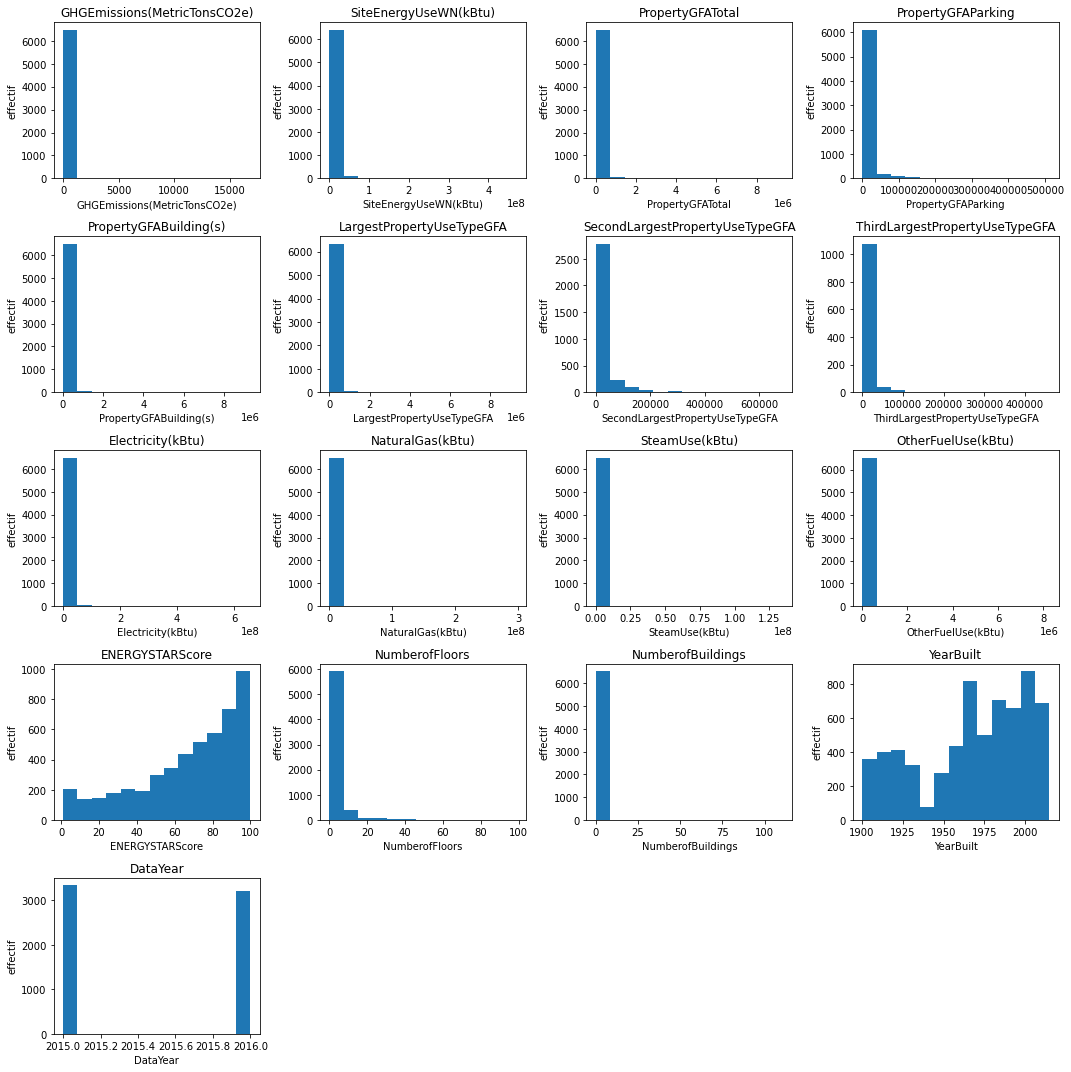

In [39]:
ncol = 4
nrow = int(np.ceil(len(quanti_variables)/ncol))
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))
for i, var in enumerate(quanti_variables) :
    locy, locx = i%4, i//4
    n_bins = int(1+np.log2(len(DATA[var])))
    axes[locx, locy].set_title(var)
    axes[locx, locy].set_xlabel(var)
    axes[locx, locy].set_ylabel("effectif")
    axes[locx, locy].hist(DATA[var], bins=n_bins)
for y in range(locy+1,4) :
    fig.delaxes(axes[-1, y])
fig.tight_layout()
plt.show()

#### Statistiques

In [40]:
stats = {"moyenne" :{}, "Q1" : {}, "Q2": {}, "Q3": {}, "std":{}, "asym": {}, "applatissement" :{} }
stats = pd.DataFrame(stats)
stats['moyenne'] = DATA[quanti_variables].mean()
stats[['Q1', 'Q2', 'Q3']] = DATA.quantile([0.25, 0.5, 0.75]).T
stats['std'] = DATA[quanti_variables].std()
stats['asym'] = DATA[quanti_variables].skew()
stats['applatissement'] = DATA[quanti_variables].kurtosis()
stats

,moyenne,Q1,Q2,Q3,std,asym,applatissement
GHGEmissions(MetricTonsCO2e),1.160569e+02,9.4775,33.175,91.815,4.844272e+02,19.071262,478.705005
SiteEnergyUseWN(kBtu),5.295297e+06,987101.0625,1927768.500,4399330.375,1.516906e+07,13.913588,285.611960
PropertyGFATotal,9.325755e+04,28380.0000,43832.000,89865.750,1.889723e+05,20.783156,887.308868
PropertyGFAParking,9.741519e+03,0.0000,0.000,0.000,3.426878e+04,6.269096,53.159418
PropertyGFABuilding(s),8.355886e+04,27231.7500,42022.500,81422.000,1.745856e+05,25.385648,1215.658049
LargestPropertyUseTypeGFA,7.716386e+04,25000.0000,39000.000,74138.250,1.695755e+05,27.775594,1394.464704
SecondLargestPropertyUseTypeGFA,2.796346e+04,4993.0000,10664.000,26466.000,5.237872e+04,4.714500,30.912727
ThirdLargestPropertyUseTypeGFA,1.132184e+04,2351.0000,5100.000,10280.000,2.641919e+04,8.781757,109.122898
Electricity(kBtu),3.634359e+06,639669.0000,1172474.000,2818601.250,1.262147e+07,26.934784,1189.785084
NaturalGas(kBtu),1.319145e+06,0.0000,301904.000,1143400.000,5.749806e+06,28.237678,1211.800581


### Exploration des données qualitatives

In [41]:
quali_variables = ["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType",\
                   "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "Outlier"]

#### Tableau des effectifs et des fréquences

In [42]:
for var in quali_variables :
    print("="*50)
    print(var)
    print('-'*30)
    df = pd.DataFrame({"effectifs":{}, "fréquences":{} })
    df['effectifs'] = DATA[var].value_counts()
    df['fréquences'] = DATA[var].value_counts(normalize=True)
    print(df)
    

BuildingType
------------------------------
                      effectifs  fréquences
NonResidential             2893    0.441814
Multifamily LR (1-4)       2011    0.307117
Multifamily MR (5-9)       1124    0.171655
Multifamily HR (10+)        215    0.032834
Nonresidential COS          149    0.022755
SPS-District K-12           109    0.016646
Campus                       46    0.007025
Nonresidential WA             1    0.000153
PrimaryPropertyType
------------------------------
                             effectifs  fréquences
Low-Rise Multifamily              1951    0.297954
Mid-Rise Multifamily              1092    0.166768
Small- and Mid-Sized Office        584    0.089188
Other                              508    0.077581
Large Office                       340    0.051924
Mixed Use Property                 258    0.039401
High-Rise Multifamily              206    0.031460
Non-Refrigerated Warehouse         187    0.028558
K-12 School                        186    0.028406

### Vérifications des variables
#### Cohérence entre les différentes consommations énergétiques et la consommation Totale
on compare la somme des différentes consommations avec la valeur de la consommation totale.  
La variable SiteEnergyUse(kBtu) puisqu'on préfère modéliser la valeur normalisée par la température.

In [43]:
df_test = pd.DataFrame()
df_test['sum'] = DATA[["Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)"]].sum(axis=1)
df_test['diff'] = DATA["SiteEnergyUse(kBtu)"] -df_test['sum']
df_test['diff_prct'] = (DATA["SiteEnergyUse(kBtu)"] -df_test['sum'])*100/DATA["SiteEnergyUse(kBtu)"]
print(df_test.head())
print(len(df_test))
print('='*50)
print(f"différence supérieur à 0% : {len(df_test[df_test['diff_prct']>0])}")
print(f"différence inférieur à 0% : {len(df_test[df_test['diff_prct']<0])}")
print(f"différence supérieur à 1% : {len(df_test[df_test['diff_prct']>1])}")
print(f"différence inférieur à -1% : {len(df_test[df_test['diff_prct']<-1])}")
print(f"min différence = {df_test['diff_prct'].min():.2f}%")
print(f"max différence = {df_test['diff_prct'].max():.2f}%")

          sum    diff  diff_prct
0   6981580.0  -152.0  -0.002177
1   8354396.0  -161.0  -0.001927
2  73132739.0 -2083.0  -0.002848
3  28229435.0  -115.0  -0.000407
4  14829350.0  -251.0  -0.001693
6548
différence supérieur à 0% : 1924
différence inférieur à 0% : 4104
différence supérieur à 1% : 34
différence inférieur à -1% : 9
min différence = -64.50%
max différence = 100.00%


La somme des différentes consommations ne correspond pas exactement à la valeurs de la variable "SiteEnergyUse(kBtu)".
Si on accepte une différence maximum de 1%, on ne supprime que 43 observations.  
C'est ce choix qui a été fait.  

In [44]:
 i = df_test[(df_test['diff_prct']<1) & (df_test['diff_prct']>-1)].index

DATA = DATA[DATA.index.isin(i)]

#### Cohérence entre la surface totale et la surface de l'immeuble + parking

In [46]:
df_test = pd.DataFrame()
df_test['sum'] = DATA[["PropertyGFAParking", "PropertyGFABuilding(s)"]].sum(axis=1)
df_test['diff'] = DATA["PropertyGFATotal"] -df_test['sum']
df_test['diff_prct'] = (DATA["PropertyGFATotal"] -df_test['sum'])*100/DATA["PropertyGFATotal"]
print(f"différence égale à 0% : {len(df_test[df_test['diff_prct'] == 0])}")
print(f"différence supérieur à 0% : {len(df_test[df_test['diff_prct']>0])}")
print(f"différence inférieur à 0% : {len(df_test[df_test['diff_prct']<0])}")
print(f"différence supérieur à 1% : {len(df_test[df_test['diff_prct']>1])}")
print(f"différence inférieur à -1% : {len(df_test[df_test['diff_prct']<-1])}")


différence égale à 0% : 6492
différence supérieur à 0% : 0
différence inférieur à 0% : 4
différence supérieur à 1% : 0
différence inférieur à -1% : 2


Le nombre d'observations incohérente étant faible, on décide de les supprimer.

In [47]:
 i = df_test[df_test['diff_prct'] == 0].index
DATA = DATA[DATA.index.isin(i)]


#### Cohérence entre la surface totale et la surface de l'activité principale


In [48]:
df_test = pd.DataFrame()
df_test['diff'] = DATA["PropertyGFATotal"] -DATA['LargestPropertyUseTypeGFA']
df_test['diff_prct'] = (DATA["PropertyGFATotal"] -DATA['LargestPropertyUseTypeGFA'])*100/DATA["PropertyGFATotal"]
print(f"différence égale à 0% : {len(df_test[df_test['diff_prct'] == 0])}")
print(f"différence supérieur à 0% : {len(df_test[df_test['diff_prct']>0])}")
print(f"différence inférieur à 0% : {len(df_test[df_test['diff_prct']<0])}")

différence égale à 0% : 2426
différence supérieur à 0% : 3319
différence inférieur à 0% : 603


il y a 603 observations où la surface totale est inférieure à la surface de l'activité principale.  
Cela semble incohérent, on supprime ces observations

In [49]:
 i = df_test[df_test['diff_prct'] >= 0].index
DATA = DATA[DATA.index.isin(i)]

### Creation de nouvelles variables
Pour faciliter la modélisation, des nouvelles variables vont être créées
#### Mix énergétique
on donne le %electricité, le %gaz, le %vapeur et le %autres de la consommation énergétique

In [50]:
for energy in ["Electricity", "NaturalGas", "SteamUse", "OtherFuelUse"] :
    col = energy+"(kBtu)"
    DATA[energy+"(%)"] = DATA[energy+'(kBtu)']/DATA['SiteEnergyUse(kBtu)']*100

On peut supprimer la variable SiteEnergyUse(kBtu), elle ne sera plus utilisée par la suite

In [51]:
DATA = DATA.drop("SiteEnergyUse(kBtu)", axis=1)

#### principale source d'énergie

In [52]:
DATA['MainEnergySource'] = DATA[["Electricity(%)", "NaturalGas(%)", "SteamUse(%)", "OtherFuelUse(%)"]].idxmax(axis=1)
DATA['MainEnergySource'].head()

0    Electricity(%)
1     NaturalGas(%)
2    Electricity(%)
3       SteamUse(%)
5    Electricity(%)
Name: MainEnergySource, dtype: object

#### Surface occupée par chaque acivité
on créé une variable par activité et on renseigne la surface assignée à cette activité.

In [53]:
use = DATA[["LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]].values
use = list(set(use.reshape((-1,))))
use = sorted([x for x in use if pd.notnull(x)])
print(f"Nombre d'utilisations différentes = {len(use)}")
print("Valeurs possibles :")
print(use)

Nombre d'utilisations différentes = 64
Valeurs possibles :
['Adult Education', 'Automobile Dealership', 'Bank Branch', 'Bar/Nightclub', 'College/University', 'Convenience Store without Gas Station', 'Convention Center', 'Courthouse', 'Data Center', 'Distribution Center', 'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office', 'Fitness Center/Health Club/Gym', 'Food Sales', 'Food Service', 'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School', 'Laboratory', 'Library', 'Lifestyle Center', 'Manufacturing/Industrial Plant', 'Medical Office', 'Movie Theater', 'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse', 'Office', 'Other', 'Other - Education', 'Other - Entertainment/Public Assembly', 'Other - Lodging/Residential', 'Other - Mall', 'Other - Public Services', 'Other - Recreation', 'Other - Restaurant/Bar', 'Other - Services', 'Other - Technology/Science', 'Other - Utility', 'Other/Specialty Hospital', 'Outpatient Rehabilitation/Physical Therapy', 'Parking', 'Per

In [54]:
pd.set_option('display.max_columns', 100)
#Initialisation des variables à 0 :
for column in use :
    DATA[column+"GFA"] = 0

# remplissage des colonnes :
for i in range(0, len(DATA)) :
    if pd.notnull(DATA["LargestPropertyUseTypeGFA"].iloc[i]):
        DATA[DATA["LargestPropertyUseType"].iloc[i]+"GFA"].iloc[i] += DATA["LargestPropertyUseTypeGFA"].iloc[i]
    if pd.notnull(DATA["SecondLargestPropertyUseTypeGFA"].iloc[i]):
        DATA[DATA["SecondLargestPropertyUseType"].iloc[i]+"GFA"].iloc[i] += DATA["SecondLargestPropertyUseTypeGFA"].iloc[i]
    if pd.notnull(DATA["ThirdLargestPropertyUseType"].iloc[i]):
        DATA[DATA["ThirdLargestPropertyUseType"].iloc[i]+"GFA"].iloc[i] += DATA["ThirdLargestPropertyUseTypeGFA"].iloc[i]
DATA.head()

C:\Users\erwan\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),Outlier,Electricity(%),NaturalGas(%),SteamUse(%),OtherFuelUse(%),MainEnergySource,Adult EducationGFA,Automobile DealershipGFA,Bank BranchGFA,Bar/NightclubGFA,College/UniversityGFA,Convenience Store without Gas StationGFA,Convention CenterGFA,CourthouseGFA,Data CenterGFA,Distribution CenterGFA,Enclosed MallGFA,Fast Food RestaurantGFA,Financial OfficeGFA,Fitness Center/Health Club/GymGFA,Food SalesGFA,Food ServiceGFA,Hospital (General Medical & Surgical)GFA,HotelGFA,K-12 SchoolGFA,LaboratoryGFA,LibraryGFA,Lifestyle CenterGFA,Manufacturing/Industrial PlantGFA,Medical OfficeGFA,Movie TheaterGFA,Multifamily HousingGFA,MuseumGFA,Non-Refrigerated WarehouseGFA,OfficeGFA,OtherGFA,Other - EducationGFA,Other - Entertainment/Public AssemblyGFA,Other - Lodging/ResidentialGFA,Other - MallGFA,Other - Public ServicesGFA,Other - RecreationGFA,Other - Restaurant/BarGFA,Other - ServicesGFA,Other - Technology/ScienceGFA,Other - UtilityGFA,Other/Specialty HospitalGFA,Outpatient Rehabilitation/Physical TherapyGFA,ParkingGFA,Performing ArtsGFA,"Personal Services (Health/Beauty, Dry Cleaning, etc)GFA",Police StationGFA,Pre-school/DaycareGFA,Prison/IncarcerationGFA,Refrigerated WarehouseGFA,"Repair Services (Vehicle, Shoe, Locksmith, etc)GFA",Residence Hall/DormitoryGFA,Residential Care FacilityGFA,RestaurantGFA,Retail StoreGFA,Self-Storage FacilityGFA,Senior Care CommunityGFA,Social/Meeting HallGFA,Strip MallGFA,Supermarket/Grocery StoreGFA,Swimming PoolGFA,Urgent Care/Clinic/Other OutpatientGFA,Vocational SchoolGFA,Wholesale Club/SupercenterGFA,Worship FacilityGFA
0,1,2015,NonResidential,Hotel,1927,1.0,12.0,88434,0.0,88434.0,Hotel,88434.0,NaN,NaN,NaN,NaN,65.0,7097539.0,2023032.0,3686160.0,1272388.0,0.0,249.43,NaN,52.799513,18.225326,28.977338,0.0,Electricity(%),0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,88434,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
1,2,2015,NonResidential,Hotel,1996,1.0,11.0,103566,15064.0,88502.0,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,51.0,8765788.0,0.0,3905411.0,4448985.0,0.0,263.51,NaN,46.747679,53.254248,0.000000,0.0,NaturalGas(%),0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,83880,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,15064.0,0,0,0,0,0,0,0,0,0,4622,0.0,0,0,0,0,0,0,0,0,0,0
2,3,2015,NonResidential,Hotel,1969,1.0,41.0,961990,0.0,961990.0,Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,18.0,75506272.0,19660404.0,49762435.0,3709900.0,0.0,2061.48,NaN,68.045930,5.072975,26.883943,0.0,Electricity(%),0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,757243,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,100000.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
3,5,2015,NonResidential,Hotel,1926,1.0,10.0,61320,0.0,61320.0,Hotel,61320.0,NaN,NaN,NaN,NaN,1.0,28363444.0,23458518.0,2769023.0,2001894.0,0.0,1936.34,High Outlier,9.809032,7.091542,83.099834,0.0,SteamUse(%),0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,61320,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0
5,9,2015,Nonresidential COS,Other,1999,1.0,2.0,97288,37198.0,60090.0,Police Station,88830.0,NaN,NaN,NaN,NaN,NaN,13045258.0,0.0,7271004.0,4781283.0,0.0,304.62,NaN,60.330349,39.672165,0.000000,0.0,Electricity(%),0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,88830,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0


Après cette modification, les variables SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA sont supprimées car trop peu renseignées

In [55]:
for col in ["SecondLargestPropertyUseType", "SecondLargestPropertyUseTypeGFA", \
            "ThirdLargestPropertyUseType", "ThirdLargestPropertyUseTypeGFA"] :
    DATA = DATA.drop(col, axis=1)

#### Modification de la notion d'outliers
les outliers ont 3 valeurs possible : null, low, high.
pour simplifier la notation, on utilise : 
- null = 0
- low = 1
- high = 2

In [56]:
DATA.loc[pd.isnull(DATA.Outlier), "Outlier"] = 0
DATA.loc[DATA.Outlier == "Low Outlier", "Outlier"] = 1
DATA.loc[DATA.Outlier == "High Outlier", "Outlier"] = 2
DATA["Outlier"].value_counts()

0    5673
2      42
1      30
Name: Outlier, dtype: int64

#### encodage du type d'immeuble 
On utilise pour cela un OneHotEncoder sur la variable BuidingType

In [57]:
encoder = OneHotEncoder()
transformed = encoder.fit_transform(DATA[['BuildingType']])
#Vérification que les colonnes n'existes pas 
test = [ col in DATA.columns for col in encoder.categories_[0] ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(encoder.categories_[0][test])
else :
    print("Les colonnes suivantes sont créées :")
    print(encoder.categories_[0])
DATA[encoder.categories_[0]] = transformed.toarray()
DATA = DATA.drop('BuildingType', axis=1)

Les colonnes suivantes sont créées :
['Campus' 'Multifamily HR (10+)' 'Multifamily LR (1-4)'
 'Multifamily MR (5-9)' 'NonResidential' 'Nonresidential COS'
 'SPS-District K-12']


In [58]:
DATA["MainEnergySource"].value_counts()
transformed = encoder.fit_transform(DATA[['MainEnergySource']])
categ = ["MainEnergySource_"+val for val in encoder.categories_[0]]
test = [ col in DATA.columns for col in categ ]
if np.any(test) : 
    print("Des colonnes existent déjà : ")
    print(categ[test])
else :
    print("Les colonnes suivantes sont créées :")
    print(categ)
DATA[categ] = transformed.toarray()
DATA = DATA.drop("MainEnergySource", axis=1)

Les colonnes suivantes sont créées :
['MainEnergySource_Electricity(%)', 'MainEnergySource_NaturalGas(%)', 'MainEnergySource_SteamUse(%)']


#### Age de l'immeuble
L'age de l'immeuble au moment du relevé sera plus représentatif que l'année de construction.  
La variable "building_age" est créé et les variables "YearBuilt" et "DataYear" sont supprimées

In [59]:
DATA["building_age"] = DATA["DataYear"] - DATA["YearBuilt"]
DATA = DATA.drop("DataYear", axis=1)
DATA = DATA.drop("YearBuilt", axis=1)

### Suppression des observations non complètes
Pour une modélisation efficace, on décide de supprimer tout simplement les observations contenant des valeurs vides.

In [60]:
selected_columns = ["GHGEmissions(MetricTonsCO2e)", "SiteEnergyUseWN(kBtu)", "OSEBuildingID", \
                   "PrimaryPropertyType", "building_age", "NumberofFloors", "NumberofBuildings", \
                   "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "LargestPropertyUseType",\
                   "LargestPropertyUseTypeGFA", "Electricity(kBtu)", "NaturalGas(kBtu)",\
                   "SteamUse(kBtu)", "OtherFuelUse(kBtu)"]
print(f"Nombre d'observations avant suppression = {len(DATA)}")
DATA = DATA.dropna(axis=0, subset=selected_columns)
print(f"Nombre d'observations après suppression = {len(DATA)}")
#DATA = DATA.dropna()
#"ENERGYSTARScore"

Nombre d'observations avant suppression = 5745
Nombre d'observations après suppression = 5741


### Correlation entre les variables et les valeurs à prédire
on utilise le coefficient de détermination : le carré du coefficient de Pearson

<AxesSubplot:>

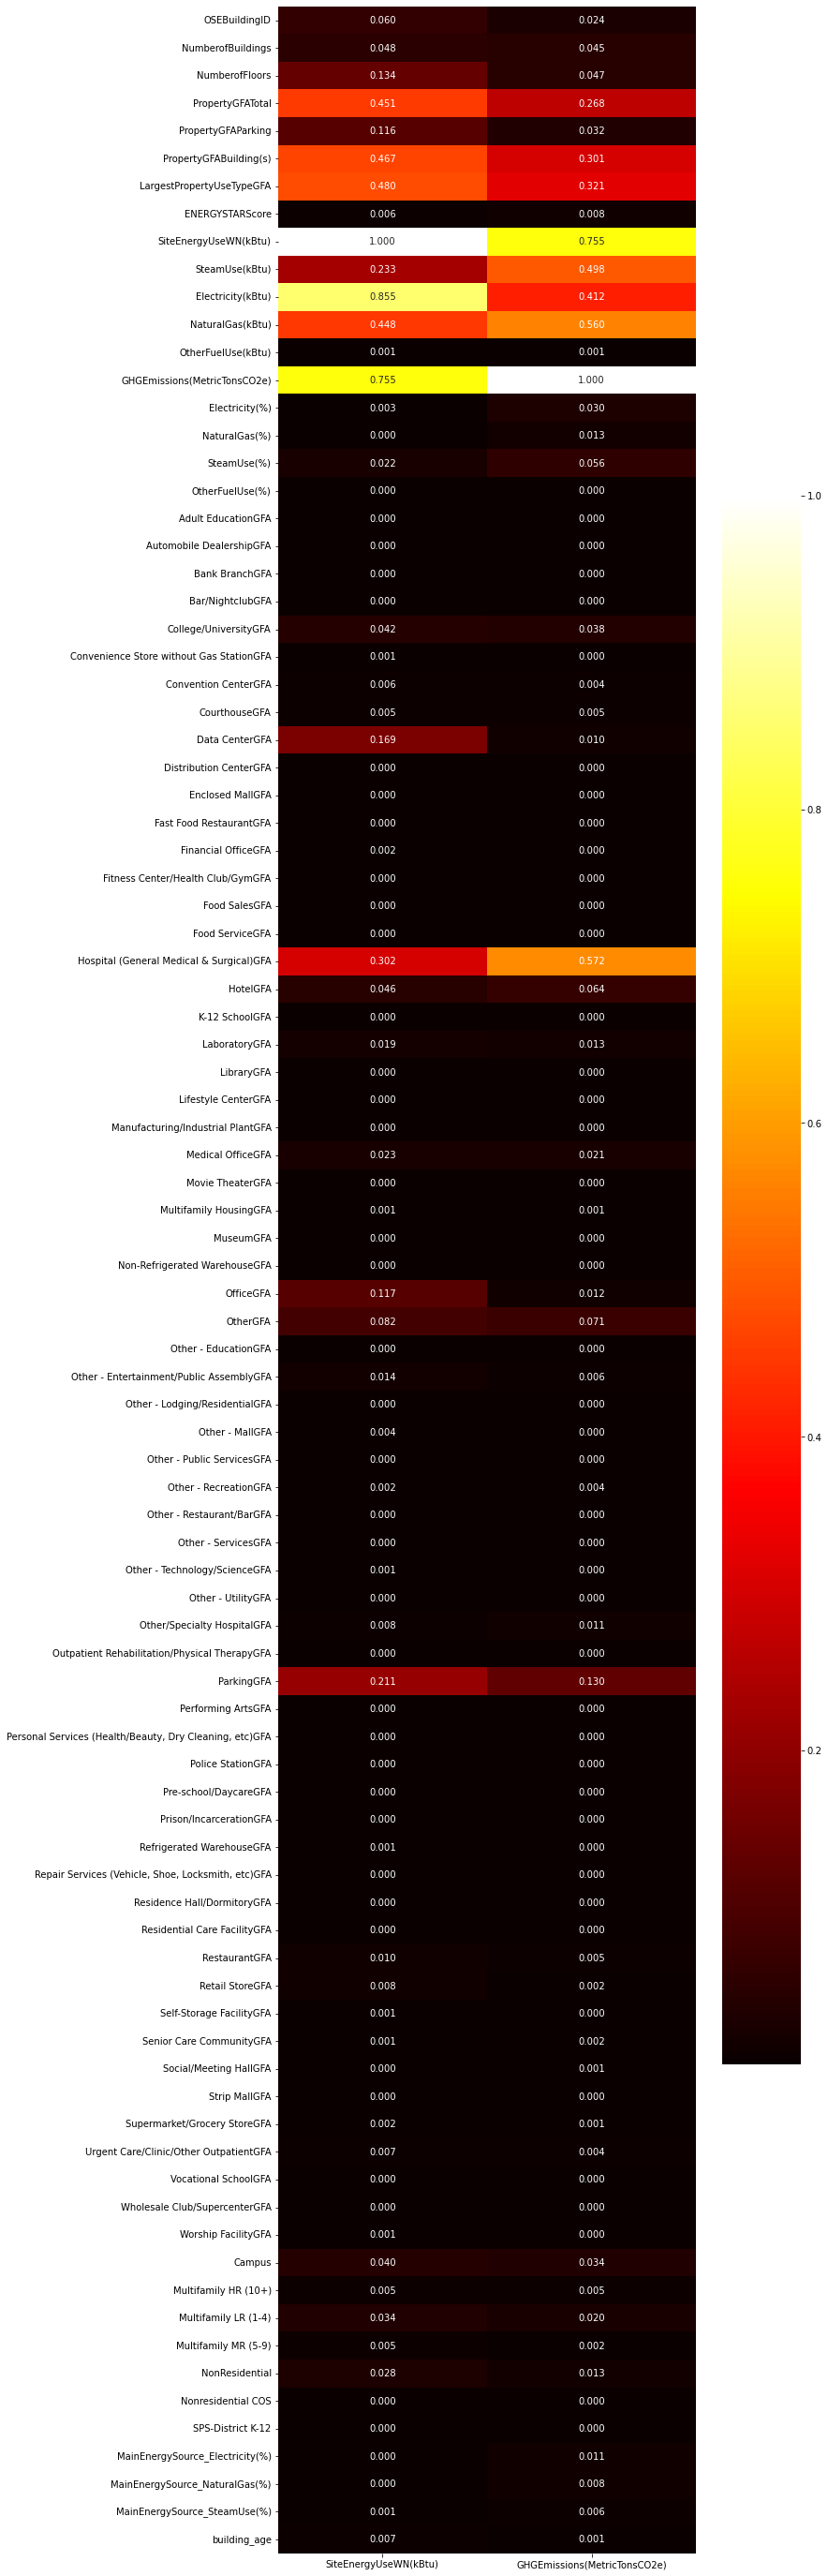

In [61]:
df_corr = DATA.corr(method='pearson', min_periods=50)
df_corr = df_corr.dropna(axis=0, how="all")
df_corr = df_corr*df_corr
df_predicted_corr = df_corr[['SiteEnergyUseWN(kBtu)','GHGEmissions(MetricTonsCO2e)']]
fig, ax = plt.subplots(figsize=(10,50))     
sns.heatmap(df_predicted_corr, annot=True,ax=ax, fmt=".3f", cmap="hot")

### Dataset pour l'ENERGYSTARScore

On va également créer un dataset contenant pour les ENERGYSTARScore.  
Un dataset différent est créé compte tenu du nombre important de valeurs manquantes pour cette variable et elle est supprimée du premier.

In [62]:
DATA_ESS = DATA.dropna(axis=0, subset=["ENERGYSTARScore"])
print(f"Nombre d'observations après suppression = {len(DATA_ESS)}")

Nombre d'observations après suppression = 4357


### imputation ENERGYSTARScore
Dans le Dataset avec des valeurs manquantes dans pour la variable ENERGYSTARScore, on va imputer les valeurs.  
Deux méthodes seront testées : impuation par la moyenne et par les KNN. 

#### Impuation par la moyenne

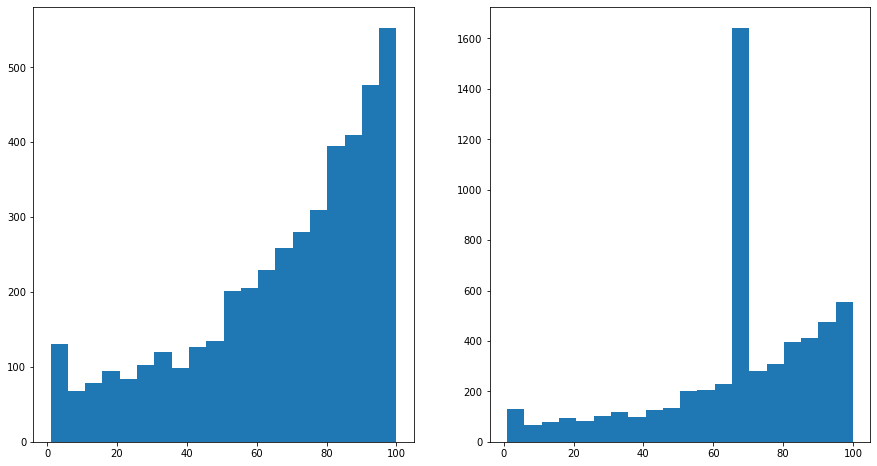

In [63]:
new_energystar_mean = DATA["ENERGYSTARScore"].copy(deep=True)
new_energystar_mean.loc[pd.isnull(new_energystar_mean)] = new_energystar_mean.mean()

# Comparaison de la nouvelle distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axs[0].hist(DATA["ENERGYSTARScore"], bins=20)
axs[1].hist(new_energystar_mean, bins=20)
plt.show()

La distribution obtenue par une imputation par la moyenne est fortement différente de la distribution initiale,  
cela signifie que la variable n'est plus représentative de l'échantillon.

#### impuation par les KNN
Recherche de la valeur de K optimal.


C:\Users\erwan\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


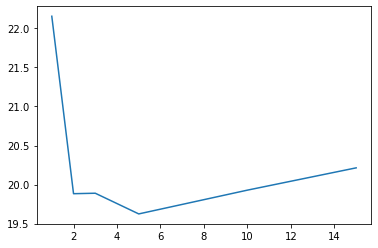

In [64]:
data = DATA[pd.notnull(DATA["ENERGYSTARScore"])].copy(deep=True).select_dtypes(['int', 'float'])
i_test = np.random.randint(0, high=len(data), size=200)
data_test = data.copy(deep=True)
data_test["ENERGYSTARScore"].iloc[i_test] = np.NaN

errors = []
fig, ax = plt.subplots()
for k in [1,2,3,5,10, 15] :
    imputer = KNNImputer(n_neighbors=k, copy=True, weights="distance")
    data_knn = pd.DataFrame(imputer.fit_transform(data_test), columns=data.columns)
    errors.append(np.mean(np.abs(data_knn["ENERGYSTARScore"].iloc[i_test].values - data["ENERGYSTARScore"].iloc[i_test].values)))
    
ax.plot([1,2,3,5,10, 15], errors)
plt.show()

Une valeur de K=5 semble donner les meilleurs résulats.

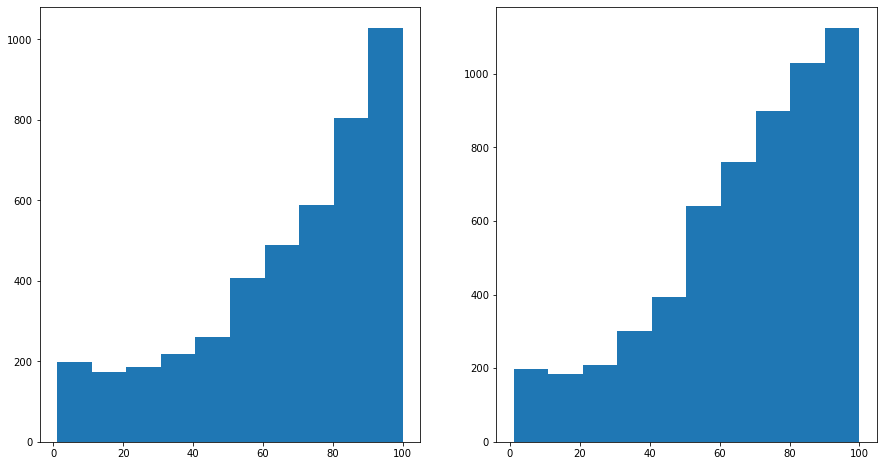

In [65]:
imputer = KNNImputer(n_neighbors=5, copy=True, weights="distance")
imputed = pd.DataFrame(imputer.fit_transform(DATA.select_dtypes(['int', 'float'])), columns=data.columns)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
axs[0].hist(DATA["ENERGYSTARScore"])
axs[1].hist(imputed["ENERGYSTARScore"])
plt.show()
DATA["ENERGYSTARScore"] = imputed["ENERGYSTARScore"]


La forme de la distribution est beaucoup moins modifiée. Nous concervons ces valeurs.

### Sauvegarde du Dataset nettoyé

In [66]:
DATA.to_csv("data/building-energy-benchmarking_cleaned.csv", sep=',', index=False)
DATA_ESS.to_csv("data/building-energy-benchmarking_EnergyStarScore_cleaned.csv", sep=',', index=False)

Variables pouvant encore etre ajoutées
encoder les variables qualitative : MainSourceEnergy, type of building
nombre d'activités dans l'immeuble